# Data Preprocessing

In [ ]:
import collections
import math
import random
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

We drop the essay responses and last online feature.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CIS700Project/profiles.csv')
df.head()
df = df.drop(columns=['essay' + str(i) for i in range(10)])
df = df.drop(columns=['last_online', ])
df.dtypes

age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object

Convert single value categorical features into one-hot encoding.

In [ ]:
one_hot_col_list = []
for col in df.columns:
  if col not in ['age', 'ethnicity', 'height', 'job', 'religion', 'speaks',]:
    one_hot_col_list.append(col)

one_hot_df = pd.get_dummies(df, columns = one_hot_col_list, dummy_na=True)

# Drop columns that contain only one unique value.

uniform_col_list = []
for col, num in zip(one_hot_df.columns, one_hot_df.nunique(dropna=False)):
  if num == 1:
    uniform_col_list.append(col)

one_hot_df = one_hot_df.drop(columns=uniform_col_list)

Convert features with lists of values into one-hot encoding.

In [ ]:
def label_list_binarize(df, column, column_idx, sanitization=lambda x: x):
  value_set = set()
  for val in df[column].unique():
    if type(val) != str:
      continue
    for token in val.split(', '):
      value_set.add(sanitization(token))

  for value in value_set:
    df[column + '_' + value] = 0
    df[column + '_nan'] = 0

  for i, row in df.iterrows():
    if type(row[column_idx]) != str:
      one_hot_df.at[i, column + '_nan'] = 1
      continue
    value_list = row[column_idx].split(', ')
    for value in value_list:
      one_hot_df.at[i, column + '_' + sanitization(value)] = 1
  return df

In [ ]:
one_hot_df = label_list_binarize(one_hot_df, 'ethnicity', 1)
one_hot_df = label_list_binarize(one_hot_df, 'speaks', 5, lambda x: x.split(' ')[0])

one_hot_df = one_hot_df.drop(columns=['ethnicity', 'speaks'])

For convenience, we drop the three data records that have NaN value for height.

In [ ]:
one_hot_df = one_hot_df[one_hot_df['height'].notna()]

For job prediction, we encode the religion feature and drop rows with NaN in the job feature.

In [ ]:
job_prediction_df = one_hot_df[one_hot_df['job'].notna()]
job_prediction_df = pd.get_dummies(job_prediction_df, dummy_na=True, columns=['religion'])

In [ ]:
job_label_list = job_prediction_df['job'].unique()
job_label_to_idx = {job: idx for idx, job in enumerate(job_label_list)}

job_prediction_df['job_class'] = job_prediction_df['job'].map(lambda x: job_label_to_idx[x])
job_prediction_df = job_prediction_df.drop(columns=['job'])

## Dimensionality Reduction for the Dataset

We use PCA to reduce the dimensionality of the dataset and find the number of dimensions to encode the information in the dataset.

In [ ]:
feature_vectors = job_prediction_df.drop(columns=['job_class'])
x = feature_vectors.to_numpy()

(51747, 521)

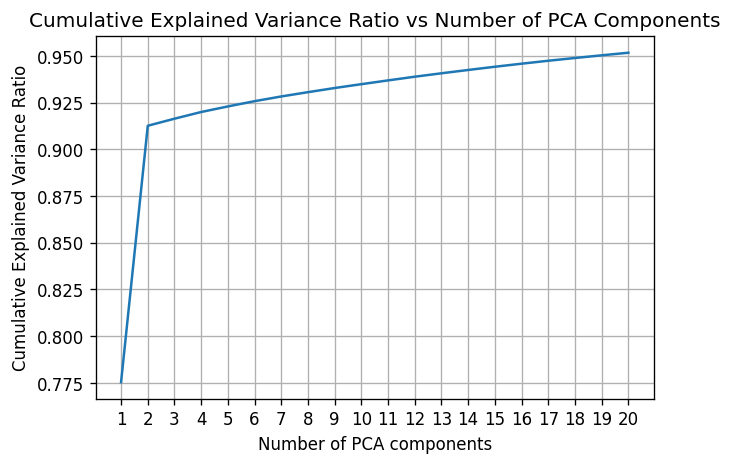

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(x)
cum_variance_ratio = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(20)]
plt.figure(dpi=120)
plt.plot(range(1, 21), cum_variance_ratio)
plt.title('Cumulative Explained Variance Ratio vs Number of PCA Components')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, 21))
plt.grid()

We now sample a private training set.

In [ ]:
np.random.seed(700)
job_prediction_subdf = job_prediction_df.sample(12_000, random_state=700)
shuffled_index = np.array(range(12_000))
np.random.shuffle(shuffled_index)
job_private_train_df = job_prediction_subdf[shuffled_index < 10_000]
job_validation_df = job_prediction_subdf[shuffled_index >= 10_000]



job_private_train_df.to_csv('/content/drive/MyDrive/CIS700Project/JobPrivateTrain.csv', index=False)
job_validation_df.to_csv('/content/drive/MyDrive/CIS700Project/JobValidate.csv', index=False)

We also store all data records no in the private dataset.

In [ ]:
job_not_in_train_df = job_prediction_df[~job_prediction_df.isin(job_private_train_df).all(1)]
job_not_in_train_df.to_csv('/content/drive/MyDrive/CIS700Project/JobOutsidePrivateTrain.csv', index=False)

We generate shadow datasets that contain real data instead of synthetic data for experiments.

In [ ]:
for i in range(50):
  job_prediction_subdf = job_prediction_df.sample(20_000)
  shuffled_index = np.array(range(20_000))
  np.random.shuffle(shuffled_index)
  real_shadow_train_df = job_prediction_subdf[shuffled_index < 10_000]
  real_shadow_test_df = job_prediction_subdf[shuffled_index >= 10_000]
  print(real_shadow_train_df.shape)
  print(real_shadow_test_df.shape)
  real_shadow_train_df.to_csv(
      '/content/drive/MyDrive/CIS700Project/RealJobShadowDatasets/real_shadow_train_{:d}.csv'.format(i),
      index=False,
  )
  real_shadow_test_df.to_csv(
      '/content/drive/MyDrive/CIS700Project/RealJobShadowDatasets/real_shadow_test_{:d}.csv'.format(i),
      index=False,
  )

## Prepare for training

In [ ]:
processed_col_dtypes = collections.defaultdict(lambda: float)
processed_col_dtypes['job_class'] = int

job_private_train_df = pd.read_csv('/content/drive/MyDrive/CIS700Project/JobPrivateTrain.csv', dtype=processed_col_dtypes)
job_validation_df = pd.read_csv('/content/drive/MyDrive/CIS700Project/JobValidate.csv', dtype=processed_col_dtypes)

In [ ]:
class JobPredictionDataset(torch.utils.data.Dataset):

  def __init__(self, df):
    self.df = df
  
  def __len__(self):
    return self.df.shape[0]
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    label = int(row['job_class'])
    example_tensor = torch.tensor(row[:-1].values.astype(np.float32), dtype=torch.float32)
    return example_tensor, label

In [ ]:
train_set = JobPredictionDataset(job_private_train_df)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)

validation_set = JobPredictionDataset(job_validation_df)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=True)

We define our models.

In [ ]:
class LogRegModel(nn.Module):
  def __init__(self):
    super(LogRegModel, self).__init__()
    self.linear = nn.Linear(521, 21)

  def forward(self, x):
    logits = self.linear(x)
    return logits

class FeedforwardNN(nn.Module):
  def __init__(self, neuron_num_list):
    super(FeedforwardNN, self).__init__()
    layer_list = []
    prev_layer_size = 521
    for neuron_num in neuron_num_list:
      layer_list.append(nn.Linear(prev_layer_size, neuron_num))
      prev_layer_size = neuron_num
    self.layer_list = nn.ModuleList(layer_list)
    self.last_layer = nn.Linear(prev_layer_size, 21)

  def forward(self, x):
    for layer in self.layer_list:
      x = F.relu(layer(x))
    logits = self.last_layer(x)
    return logits

In [ ]:
def get_accuracy(model, data_loader, device):
  total_example_num = 0
  total_corr = 0
  for x, y in data_loader:
    pred = model(x.to(device))
    pred_label = torch.argmax(pred, 1)
    num_corr = (pred_label == y.to(device)).sum()
    total_example_num += y.shape[0]
    total_corr += num_corr
  return float(total_corr) / total_example_num

We define our training loop.

In [ ]:
def train_model(model, optimizer, loss_func, epoch_num, device, show_steps=True, epoch_output_interval=1):
  model.to(device)
  val_acc_list = []
  train_acc_list = []
  loss_list = []

  for e in range(epoch_num):
    train_num_corr = 0
    epoch_example_num = 0
    step_count = 0
    cum_loss = 0.
    step_interval_example_num = 0
    for x, y in train_loader:
      step_count += 1
      pred = model(x.to(device))
      pred_label = torch.argmax(pred, 1)
      num_corr = (pred_label == y.to(device)).sum()
      epoch_example_num += y.shape[0]
      train_num_corr += num_corr
      loss = loss_func(pred, y.to(device))
      cum_loss += loss
      step_interval_example_num += y.shape[0]
      loss.backward()
      with torch.no_grad():
        optimizer.step()
      if step_count % 50 == 0:
        avg_loss = cum_loss / step_interval_example_num
        loss_list.append(avg_loss.item())
        if show_steps:
          print('Step {:d} avg loss: {:.4f}'.format(step_count, avg_loss))
        cum_loss = 0.
        step_interval_example_num = 0
    train_acc = float(train_num_corr) / epoch_example_num
    val_acc = get_accuracy(model, validation_loader, device)
    if (e + 1) % epoch_output_interval == 0:
      print('Epoch {:d}, train acc: {:.4f}, val acc: {:.4f}'.format(e, train_acc, val_acc))
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  return loss_list, train_acc_list, val_acc_list

In [ ]:
def smooth_acc(interval, acc_list):
  smoothed_list = []
  for i in range(len(acc_list)):
    interval_start = max(0, i - interval)
    interval_end = min(len(acc_list), i + interval + 1)
    avg = sum(acc_list[interval_start:interval_end]) / float(interval_end - interval_start)
    smoothed_list.append(avg)
  return smoothed_list

## Training

The hyperparameters are hard coded.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epoch_num = 40
loss_func = nn.CrossEntropyLoss()
model = LogRegModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_list, train_acc_list, val_acc_list = train_model(model, optimizer, loss_func, epoch_num, device, show_steps=True)

In [ ]:
architecture_list = [(500, 100, 50),]
architecture_results = {}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for architecture in architecture_list:
  print('Testing architecture {}'.format(architecture))
  epoch_num = 500
  loss_func = nn.CrossEntropyLoss()
  model = FeedforwardNN(architecture)
  lr = 5e-6
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  architecture_results[architecture] = train_model(model, optimizer, loss_func, epoch_num, device, show_steps=False, epoch_output_interval=50)
  torch.save(model.state_dict(), 'overfit_final_model.pt')

## Attack Preparation

We first sample 5,000 data records from the whole dataset. These data records are what the attacker would use to learn statistical information about the data records and generate synthetic datasets.

In [ ]:
attacker_job_df = job_prediction_df.sample(5_000, random_state=347)

attacker_job_df.to_csv('/content/drive/MyDrive/CIS700Project/AttackerJobData.csv', index=False)


Learn the statistical information from the sample data.

In [ ]:
attacker_job_df = pd.read_csv('/content/drive/MyDrive/CIS700Project/AttackerJobData.csv')

In [ ]:
one_value_categorical_features = set([col for col in df.columns if col not in [
    'age', 'ethnicity', 'height', 'speaks', 'job',
]])

data_distribution = {}

for label in attacker_job_df.job_class.unique():
  class_df = attacker_job_df[attacker_job_df['job_class'] == label]
  class_distribution = {}

  for col, mean in zip(class_df.columns, class_df.mean()):
    if col.split('_')[0] in one_value_categorical_features:
      feature = col.split('_')[0]
    elif col[:9] in ['body_type', 'ethnicity']:
      feature = col[:9]
    elif col[:6] == 'speaks':
      feature = 'speaks'
    else:
      continue
    if feature not in class_distribution:
      class_distribution[feature] = {}
    class_distribution[feature][col] = mean
  
  age_log = class_df.age.map(math.log)
  class_distribution['age'] = {}
  class_distribution['age']['log_mean'] = age_log.mean()
  class_distribution['age']['log_std'] = age_log.std()

  class_distribution['height'] = {}
  class_distribution['height']['mean'] = class_df.height.mean()
  class_distribution['height']['std'] = class_df.height.std()

  data_distribution[label] = class_distribution

class_distribution = dict(attacker_job_df.job_class.value_counts(normalize=True, sort=False))

In [ ]:
def sample_multinomial(distribution_dict):
  random_val = random.random()
  cum_prob = 0.
  for key, val in distribution_dict.items():
    cum_prob += val
    if random_val < cum_prob:
      return key

def generate_dataset_from_distribution(data_distribution, data_num):
  data_list = []
  for i in range(data_num):
    label = sample_multinomial(class_distribution)
    row_dict = {'job_class': label}
    label_distribution = data_distribution[label]
    for feature, info_dict in label_distribution.items():
      if feature == 'age':
        age_log = np.random.normal(info_dict['log_mean'], info_dict['log_std'])
        row_dict['age'] = math.exp(age_log)
      elif feature == 'height':
        row_dict['height'] = np.random.normal(info_dict['mean'], info_dict['std'])
      elif feature in ['ethnicity', 'speaks']:
        for col, mean in info_dict.items():
          if random.random() < mean:
            row_dict[col] = 1
          else:
            row_dict[col] = 0
      else:
        sampled_val = sample_multinomial(info_dict)
        for col in info_dict:
          if sampled_val == col:
            row_dict[col] = 1
          else:
            row_dict[col] = 0
    data_list.append(row_dict)
  return pd.DataFrame(data_list, columns=attacker_job_df.columns)

We then generate the synthetic shadow datasets.

In [ ]:
for i in range(100):
  shadow_train_dataset = generate_dataset_from_distribution(data_distribution, 10_000)
  shadow_test_dataset = generate_dataset_from_distribution(data_distribution, 10_000)
  shadow_train_dataset.to_csv('/content/drive/MyDrive/CIS700Project/JobShadowDatasets/shadow_train_{:d}.csv'.format(i), index=False)
  shadow_test_dataset.to_csv('/content/drive/MyDrive/CIS700Project/JobShadowDatasets/shadow_test_{:d}.csv'.format(i), index=False)

The shadow models are trained using a separate script to run on Kaggle.

### Training attack models using neural networks

In [ ]:
import json
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class AttackDataset(torch.utils.data.Dataset):

  def __init__(self, dataset_dir, label_index):
    dataset_list = []
    self.train_tensor = torch.load(os.path.join(dataset_dir, 'class_{:d}_train.pt'.format(label_index)))
    self.test_tensor = torch.load(os.path.join(dataset_dir, 'class_{:d}_test.pt'.format(label_index)))

  def __len__(self):
    return self.train_tensor.shape[0] + self.test_tensor.shape[0]

  def __getitem__(self, idx):
    if idx >= self.train_tensor.shape[0]:
      idx -= self.train_tensor.shape[0]
      return self.test_tensor[idx].clone().detach(), 0
    else:
      return self.train_tensor[idx].clone().detach(), 1

class AttackNN(nn.Module):
  def __init__(self, neuron_num_list):
    super(AttackNN, self).__init__()
    layer_list = []
    prev_layer_size = 21
    for neuron_num in neuron_num_list:
      layer_list.append(nn.Linear(prev_layer_size, neuron_num))
      prev_layer_size = neuron_num
    self.layer_list = nn.ModuleList(layer_list)
    self.last_layer = nn.Linear(prev_layer_size, 1)

  def forward(self, x):
    for layer in self.layer_list:
      x = F.relu(layer(x))
    logits = self.last_layer(x)
    return logits

def get_accuracy(model, data_loader):
  total_example_num = 0
  total_corr = 0
  for x, y in data_loader:
    pred = model(x.to(device))
    pred_label = (pred > 0).long().squeeze()
    num_corr = (pred_label == y.to(device)).sum()
    total_example_num += y.shape[0]
    total_corr += num_corr
  return float(total_corr) / total_example_num

def train_model(
    model,
    train_loader,
    optimizer,
    loss_func,
    epoch_num,
    device,
    validation_loader=None,
    show_steps=True,
    epoch_output_interval=1,
):
  model.to(device)
  val_acc_list = []
  train_acc_list = []
  loss_list = []

  for e in range(epoch_num):
    train_num_corr = 0
    epoch_example_num = 0
    step_count = 0
    cum_loss = 0.
    step_interval_example_num = 0
    for x, y in train_loader:
      step_count += 1
      pred = model(x.to(device))
      pred_label = (pred > 0).long().squeeze()
      num_corr = (pred_label == y.to(device)).sum()
      epoch_example_num += y.shape[0]
      train_num_corr += num_corr
      loss = loss_func(pred.squeeze(), y.float().to(device))
      cum_loss += loss
      step_interval_example_num += y.shape[0]
      loss.backward()
      with torch.no_grad():
        optimizer.step()
      if step_count % 10 == 0:
        avg_loss = cum_loss / step_interval_example_num
        loss_list.append(avg_loss.item())
        if show_steps:
          print('Step {:d} avg loss: {:.4f}'.format(step_count, avg_loss))
        cum_loss = 0.
        step_interval_example_num = 0
    train_acc = float(train_num_corr) / epoch_example_num
    train_acc_list.append(train_acc)
    if validation_loader is not None:
      val_acc = get_accuracy(model, validation_loader)
      val_acc_list.append(val_acc)
    if (e + 1) % epoch_output_interval == 0:
      if validation_loader is not None:
        print('Epoch {:d}, train acc: {:.4f}, val acc: {:.4f}'.format(e, train_acc, val_acc))
      else:
        print('Epoch {:d}, train acc: {:.4f}'.format(e, train_acc))

  return model, loss_list, train_acc_list, val_acc_list


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

results_dict = {}

epoch_num = 2000
lr = 1e-6
neuron_num = 256

for class_label in [6,]:
  print(class_label)

  train_set = AttackDataset('/content/drive/MyDrive/CIS700Project/attack_datasets_combined/shadow_model_0-39', class_label)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
  test_set = AttackDataset('/content/drive/MyDrive/CIS700Project/attack_datasets_combined/shadow_model_40-49', class_label)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False)

  loss_func = nn.BCEWithLogitsLoss()
  model = AttackNN((neuron_num,))
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.)
  model, loss_list, train_acc_list, val_acc_list = train_model(
      model,
      train_loader,
      optimizer,
      loss_func,
      epoch_num,
      device,
      validation_loader=test_loader,
      show_steps=False,
      epoch_output_interval=10,
  )

  results_dict[class_label] = {}
  results_dict[class_label]['loss_list'] = loss_list
  results_dict[class_label]['train_acc_list'] = train_acc_list
  results_dict[class_label]['val_acc_list'] = val_acc_list

with open('./{:d}_epoch={:d}_results.json'.format(neuron_num, epoch_num), 'w') as f:
  json.dump(to_write_dict, f)


### Train attack models using random forest

In [ ]:
import sklearn
import torch
import numpy as np

training_label_to_data = []

for label_index in range(21):

    train_pos_data = torch.load('/content/drive/MyDrive/CIS700Project/overfit_attack_datasets_combined/shadow_model_0-19/class_{:d}_train.pt'.format(label_index))
    train_neg_data = torch.load('/content/drive/MyDrive/CIS700Project/overfit_attack_datasets_combined/shadow_model_0-19/class_{:d}_test.pt'.format(label_index))
    test_pos_data = torch.load('/content/drive/MyDrive/CIS700Project/overfit_attack_datasets_combined/shadow_model_20-24/class_{:d}_train.pt'.format(label_index))
    test_neg_data = torch.load('/content/drive/MyDrive/CIS700Project/overfit_attack_datasets_combined/shadow_model_20-24/class_{:d}_test.pt'.format(label_index))

    x_train = np.concatenate((train_pos_data.detach().numpy(), train_neg_data.detach().numpy()))
    y_train = np.concatenate((np.ones(train_pos_data.shape[0]), np.zeros(train_neg_data.shape[0])))

    x_test = np.concatenate((test_pos_data.detach().numpy(), test_neg_data.detach().numpy()))
    y_test = np.concatenate((np.ones(test_pos_data.shape[0]), np.zeros(test_neg_data.shape[0])))

    training_label_to_data.append((x_train, y_train, x_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_val_accuracies = []
optimal_configurations = []
optimal_models = []

for label_index in range(21):

  print('Testing label index {:d}'.format(label_index))

  x_train, y_train, x_test, y_test = training_label_to_data[label_index]

  best_acc = 0.
  best_config = None
  best_model = None

  for tree_num in range(1, 21):
    for depth in range(1, 21):
      clf = RandomForestClassifier(n_estimators=tree_num, max_depth=depth, verbose=0)
      clf = clf.fit(x_train, y_train)

      val_acc = clf.score(x_test, y_test)
      if val_acc > best_acc:
        best_acc = val_acc
        best_config = (tree_num, depth)
        best_model = clf
  
  print(best_acc)
  max_val_accuracies.append(best_acc)
  optimal_configurations.append(best_config)
  optimal_models.append(best_model)

In [ ]:
val_avg_acc = 0.
total_size = sum([len(training_label_to_data[i][0]) for i in range(21)])

for label_index in range(21):
  print('label: {:d}, train dataset size: {:d}, highest val accuracy: {:.4f}'.format(
      label_index,
      len(training_label_to_data[label_index][0]),
      max_val_accuracies[label_index],
  ))
  val_avg_acc += (float(len(training_label_to_data[label_index][0])) / total_size) * max_val_accuracies[label_index]

print(val_avg_acc)


### Test random forest models

In [ ]:
import sklearn
import torch
import numpy as np

testing_label_to_data = []

for label_index in range(21):

    pos_data = torch.load('/content/drive/MyDrive/CIS700Project/target_model_combined/overfit_target_model/class_{:d}_train.pt'.format(label_index))
    neg_data = torch.load('/content/drive/MyDrive/CIS700Project/target_model_combined/overfit_target_model/class_{:d}_test.pt'.format(label_index))

    x_test = np.concatenate((pos_data.detach().numpy(), neg_data.detach().numpy()))
    y_test = np.concatenate((np.ones(pos_data.shape[0]), np.zeros(neg_data.shape[0])))

    testing_label_to_data.append((x_test, y_test))

In [ ]:
total_corr = 0
total_num = 0
eval_acc_list = []

for label_index in range(21):

  x_test, y_test = testing_label_to_data[label_index]

  clf = optimal_models[label_index]

  val_acc = clf.score(x_test, y_test)
  eval_acc_list.append(clf.score(x_test, y_test))

  pred = clf.predict(x_test)
  total_corr += (pred == y_test).sum()
  total_num += y_test.shape[0]

final_acc = float(total_corr) / total_num
print(final_acc)

0.7274
